# 예제 코드

## 1. set-up

In [4]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')


# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [10]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')


# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


# tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 현재 이미지에는 라벨 데이터가 따로 없습니다. # 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서
# 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다. # 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


# resize & change type
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

# data 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0285-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1080
Pneumonia images count in training set: 3105
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  False
624


## 3. 데이터 시각화

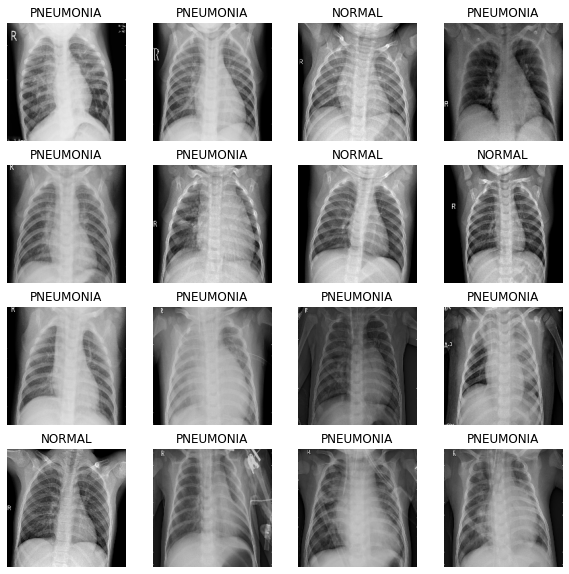

In [3]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# for문으로 정상/비정상 분할

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [4]:
# Convolution block을 만듭니다. 
# conv_block()의 구성은 Convolution을 두 번 진행
# Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
# then Max Pooling 
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


# make Dense Block function
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [5]:
# model build function
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [6]:
# weight_for_0은 'Normal' 이미지에 사용할 weight
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅 
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


## 6. 모델 훈련

In [7]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 200ms/step - loss: 0.3857 - accuracy: 0.8147 - precision: 0.9566 - recall: 0.7852 - val_loss: 0.5696 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.2178 - accuracy: 0.9167 - precision: 0.9744 - recall: 0.9115 - val_loss: 0.8458 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 197ms/step - loss: 0.1955 - accuracy: 0.9291 - precision: 0.9768 - recall: 0.9263 - val_loss: 0.1270 - val_accuracy: 0.9529 - val_precision: 0.9815 - val_recall: 0.9550
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1737 - accuracy: 0.9277 - precision: 0.9807 - recall: 0.9206 - val_loss: 0.4550 - val_accuracy: 0.8048 - val_precision: 0.7929 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1662 - accura

## 7. 결과 확인

39/39 [==============================] - 5s 118ms/step - loss: 2.0269 - accuracy: 0.6266 - precision: 0.6260 - recall: 1.0000
Loss: 2.0269250869750977,
Accuracy: 0.6266025900840759,
Precision: 0.6260032057762146,
Recall: 1.0


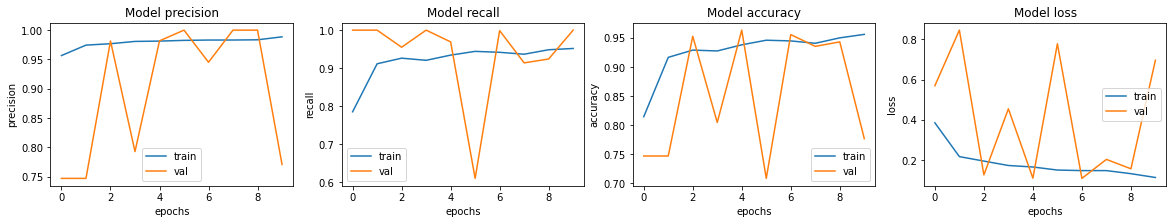

In [8]:
# 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


# 테스트 데이터로 모델 평가
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# 실습 코드

## Step 1. 실험환경 Set-up

In [9]:
BATCH_SIZE = 16
EPOCHS = 1

## Step 2. 데이터 준비하기

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. ResNet-18 구현

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add

# Residual Block 구성
def residual_block(x, filters, kernel_size=3, stride=1):
    # Convolution Layer1
    x_shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Convolution Layer2
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip Connection
    if stride != 1 or x.shape[-1] != x_shortcut.shape[-1]:
        x_shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_shortcut)
    
    x = tf.keras.layers.add([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [26]:
# ResNet-18 모델 구현
def build_resnet18_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model

In [32]:
# ResNet-18 모델 생성
input_shape = (180, 180, 3)
num_classes = 2  # 정상/폐렴
model = build_resnet18_model(input_shape, num_classes)

In [33]:
# 데이터 imbalance 처리
weight_for_0 = 1.0 / COUNT_NORMAL
weight_for_1 = 1.0 / COUNT_PNEUMONIA

class_weight = {0: weight_for_0, 1: weight_for_1}

In [34]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
# 모델 요약
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 90, 90, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 90, 90, 64)   256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 90, 90, 64)   0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

In [36]:
# 학습
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/10


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


In [37]:
# 평가
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1269 test_step
        self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


In [ ]:
# 시각화
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)

### 회고

이번 Node8, 9가 정말 어려웠고 개념은 이해를 했지만 구현 코드는 간단하게 넘긴 후폭풍으로 퀘스트를 진행하는 내내 이해가 부족하다는 것을 다시금 깨닫게 되었다.
기존 CNN 모델에서 다른 모델로 변경하는 중 모델링 학습 부분에서 계속 에러가 발생하였고, 전처리 과정에서 learning_rate_schedule이나 early_stopping, drop_out 등을 적용하면서 코드를 작성하기에 시간이 부족하다는 점이 너무나 아쉽게 느껴졌다. 배운 내용을 꾸준히 복습하지만 아직까지 벽이라는게 느껴져서 어떤식으로 공부해야 CV부분을 잘 할 수 있을지 공부법에 대해 생각좀 해야겠다.   